# 2d thermo-mechanical subduction with embedded fault

This subduction model makes use of two key objects from the UWSubduction module (https://github.com/dansand/UWsubduction)

## embedded fault

The first is an object that we refer to generically as an __embedded fault__ (see _Improving subduction interface implementation in dynamic numerical models, Solid Earth, 2019_)

For historical reasons, the formal type of an embedded fault is an`interface2D`, ( `UWsubduction.interfaces.interface2D.interface2D`)

In the context of a 2D continuum flow model, an embedded fault is a basically a 1d manifold (line) that we advect with the flow, and can be used to maintain and constrain a finite region of distinct material properties. In this example, the embedded fault approach is sued to simulate the subduction interface in a 2d thermo-mechanical simulution. 



Simple examples of initialising and embedded faults (interface2D) are found in the notebooks here: 

* `UWsubduction/Background/interfaces`

## tectonic model

The tectonic model is a object that encapsulates a plate/boundary configuration, primarly to allow the creation of initial thermal conditions. Note that this tectonic model cpncept is currently limited to a 2d models (i.e vertical cross sections)  

The user creates a tectonic model object `UWsubduction._tectonicmodel.TectonicModel`, and then sets the location of various plate boundaries, as well as information about the age (or spreading ratee, which creates the temperature structure of the surface plates. 

The tectonic model is also used to generate the temperature perturbation of slabs extennding into the mantle, as well as the embedded fault that represents the subduction interface.

Simple demonstrations of tectonic model object are found in the notebooks here: 

* `UWsubduction/Background/tectonicModel`


## other notes

The user should remove visualisation from the python script before running the model on raijin.




In [45]:
import sys
import os
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator
import pickle
import pint
import warnings; warnings.simplefilter('ignore')
from pint import UnitRegistry

In [46]:
import UWsubduction as usub
import UWsubduction.params as params 
import UWsubduction.utils as utils
from UWsubduction.utils import checkpoint
from underworld import scaling as sca

## Create output directory structure

The following code block sets up some output directories.

The results for a single model run are placed in a directory: `results/Model/ModelNum`, with `results` being built in the location where the notebook/script is run from. 

The variables `Model` and `ModelNum` can be also be passed as command line arguments, when running this model in script form.

Note that restarting from checkpoints is supported, and will take place when a model is run with the same  `Model` and `ModelNum` as previous run (more on this later)

In [47]:
#Model letter identifier demarker
Model = "T"

#Model number identifier demarker:
ModNum = 0

#Check for command line arguments, 
#any isolated letter/integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg
                
                

#Standard output directory setup

outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
xdmfPath = outputPath + 'xdmf/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(xdmfPath):
        os.makedirs(xdmfPath)
        
uw.barrier()

## Initialize checkpointing

In the following code block `cp` is a checkpoint object. 

It will be used to orchestrate the loading and saving of objects required for checkpointing

The checkpoint class is defined in: UWsubduction/utils/checkpoint.py

In [48]:
#*************CHECKPOINT-BLOCK**************#

#cp = checkpoint(outputPath + 'checkpoint/', loadpath='./results/A/1/checkpoint/10')
cp = checkpoint(outputPath + 'checkpoint/')


if cp.restart:
    print('restarting from checkpoint {}'.format(cp.step()))
#*************CHECKPOINT-BLOCK**************#


## Parameters / Scaling

Parameters are stored in EasyDicts which are  python dictionaries that support an attribute-like notation (dot) for keys/values (https://github.com/makinacorpus/easydict)

We have separated the set of physical paramters (e.g. the gas constant) from model parameters (such as the depth of the domain, resolution).


In the followiing code blocks `pd` refers to the (dimensional) physical paramater dictionary, while `md` refers to the (dimensional) model paramter dictionary.

Underword2 uses pint to assign dimensions. 


Ultimately, the model is based on a non-dimensional equivalent system. Dimensionless versions of the parameter dictionaries are created using a utility function, as discussed below. 


For more information see, `UWsubduction/Background/scaling`


In [49]:
#set up the units registy
ur = uw.scaling.units

In [50]:
#pd refers to dimensional physical parameters
pd = edict({})


#Main physical paramters (thermal convection parameters)
pd.refDensity = 3300.* ur.kilogram / ur.meter**3                    #reference density
pd.refGravity = 9.8* ur.metre / ur.second**2                        #surface gravity
pd.refDiffusivity = 1e-6 *ur.metre**2 / ur.second                   #thermal diffusivity
pd.refExpansivity = 3e-5/ur.kelvin                                  #surface thermal expansivity
pd.refViscosity = 1e20* ur.pascal* ur.second
pd.refLength = 2900*ur.km
pd.gasConstant = 8.314*ur.joule/(ur.mol*ur.kelvin)                  #gas constant
pd.specificHeat = 1250.4*ur.joule/(ur.kilogram* ur.kelvin)          #Specific heat (Jkg-1K-1)
pd.potentialTemp = 1573.*ur.kelvin                                  #mantle potential temp (K)
pd.surfaceTemp = 273.*ur.kelvin                                     #surface temp (K)

#the underscores here represent the temperatures shifted by the value of the surface temp
#when non-dimensionalized, these values will range from 0 - 1 
pd.potentialTemp_ = pd.potentialTemp - pd.surfaceTemp
pd.surfaceTemp_ = pd.surfaceTemp - pd.surfaceTemp

#main rheology parameters
pd.cohesionMantle = 20.*ur.megapascal                              #mantle cohesion in Byerlee law
pd.frictionMantle = ur.Quantity(0.1)                                           #mantle friction coefficient in Byerlee law (tan(phi))
pd.frictionMantleDepth = pd.frictionMantle*pd.refDensity*pd.refGravity
pd.diffusionPreExp = 1.87e9*ur.pascal*ur.second                  #pre-exp factor for diffusion creep
pd.diffusionEnergy = 3e5*ur.joule/(ur.mol)
pd.diffusionEnergyDepth = pd.diffusionEnergy*(1./pd.gasConstant)
pd.diffusionEnergyLM = 2e5*ur.joule/(ur.mol)
pd.diffusionEnergyLMDepth = pd.diffusionEnergyLM*(1./pd.gasConstant)
pd.diffusionVolume=5.0e-6*ur.meter**3/(ur.mol)
pd.diffusionVolumeDepth=pd.diffusionVolume.magnitude*pd.refDensity.magnitude*pd.refGravity.magnitude*ur.joule/(ur.mol*pd.gasConstant*ur.meter)
pd.diffusionVolumeLM=1.5e-6*ur.meter**3/(ur.mol)
pd.diffusionVolumeLMDepth=pd.diffusionVolumeLM.magnitude*pd.refDensity.magnitude*pd.refGravity.magnitude*ur.joule/(ur.mol*pd.gasConstant*ur.meter)
pd.viscosityFault = 2e19*ur.pascal  * ur.second
pd.frictionFault = 10.*ur.megapascal
pd.adiabaticTempGrad = (pd.refExpansivity*pd.refGravity*pd.potentialTemp)/pd.specificHeat
pd.yieldStressMax=200*ur.megapascal
pd.lowerMantleViscFac = ur.Quantity(5.0)

#this section sets the lower mantle pre-exp factor, so that the viscosity is equal to
#the UM value at transition depth. 
dE = pd.diffusionEnergy.magnitude - pd.diffusionEnergyLM.magnitude
dV = pd.diffusionVolume.magnitude - pd.diffusionVolumeLM.magnitude
adT = pd.adiabaticTempGrad.magnitude*660e3
denom  = pd.gasConstant.to_base_units().magnitude*(pd.potentialTemp.magnitude + adT )
fac = np.exp((dE + pd.refDensity.magnitude*pd.refGravity.magnitude*660e3*dV )/(denom) )

pd.diffusionPreExpLM = pd.diffusionPreExp*fac 


In [51]:
#md refers to dimensional model parameters
md = edict({})

#Model geometry, and misc Lengths used to control behaviour
md.depth=1000*ur.km                                                #Model Depth
md.aspectRatio=5.0
#lengths, factors relating to subduction fault behaviour
md.faultViscDepthTaperStart = 100*ur.km
md.faultThickness = 10.*ur.km
md.faultLocFac = 1.                                                #this is the relative location of the fault in terms of the fault thickess from the top of slab
md.faultDestroyDepth = 500*ur.km
md.lowerMantleDepth=660.*ur.km
md.lowerMantleTransWidth=100.*ur.km
#Slab and plate init. parameters
md.subZoneLoc=100*ur.km                                           #X position of subduction zone...km
md.slabInitMaxDepth=150*ur.km
md.radiusOfCurv = 200.*ur.km                                        #radius of curvature
md.slabAge=50.*ur.megayears                                      #age of subduction plate at trench
md.upperPlateAgeAtTrench=10.*ur.megayears                                        #age of uppeer plate
#numerical and computation params
md.res=48
md.ppc=25                                                         #particles per cell
md.elementType="Q1/dQ0"
#md.elementType="Q2/dPc1"
md.refineHoriz = True
md.refineVert = True
md.meshRefineFactor = 0.7
md.nltol = 0.01
md.penaltyMethod = True
md.viscosityMin = 1e18* ur.pascal * ur.second
md.viscosityMax = 1e24* ur.pascal * ur.second
md.checkpointEvery=100
md.restartParams=True #read in saved checkpoint md/pd 
md.harmonicAvg=True
md.plasticInterface = True
md.filesMyr = 0.25*ur.megayears
md.slade=False
md.courantFix = 1.0
md.maxSteps = 5000
md.faultppe = 4.    #particles per element in the fault swarm

## Non-dimensionalisation 

This section defines a set of scaling parameters, which dertermine how the system will be non-dimensionalized. 

The `build_nondim_dict` function creates dimensionless versions of the parameter dictionaries (called `npd`, `nmd`)

The Rayleigh number is defined, as well as a scale called `pressureDepthGrad', which is used to non-dimensonalise the  coefficient of friction , so it can written as a coefficient that multiplies the dimensionless depth (rather than the dimensionless pressure)

In [52]:
scaling_coefficients = sca.get_coefficients()

#instead of importing from the params submodule, we'll explicity set the scaling values
KL = pd.refLength
KT = pd.potentialTemp - pd.surfaceTemp
Kt = KL**2/pd.refDiffusivity            #we use a diffusive time scale 
KM = pd.refViscosity * KL * Kt

scaling_coefficients["[length]"]      = KL.to_base_units()
scaling_coefficients["[temperature]"] = KT.to_base_units()
scaling_coefficients["[mass]"]        = KM.to_base_units()
scaling_coefficients["[time]"] =        Kt.to_base_units()


#build the dimensionless paramter / model dictionaries
npd = params.build_nondim_dict(pd  , sca)   
nmd = params.build_nondim_dict(md  , sca)
ndimlz = sca.non_dimensionalise

assert ndimlz(pd.refLength) == 1.0


#Important to remember the to_base_units conversion here
rayleighNumber = ((pd.refExpansivity*pd.refDensity*pd.refGravity*(pd.potentialTemp - pd.surfaceTemp)*pd.refLength**3).to_base_units() \
                  /(pd.refViscosity*pd.refDiffusivity).to_base_units()).magnitude

pressureDepthGrad = ((pd.refDensity*pd.refGravity*pd.refLength**3).to_base_units()/(pd.refViscosity*pd.refDiffusivity).to_base_units()).magnitude

In [53]:
#print the timescale 
if uw.nProcs() == 1:
    s2myr = 3600.*24*365*1e6
    print('Dimensionless time to Myr conversion is {}'.format( Kt.to_base_units().magnitude/s2myr ))


Dimensionless time to Myr conversion is 266679.350583


In [54]:
#*************CHECKPOINT-BLOCK**************#


pint.set_application_registry(ur) #https://github.com/hgrecco/pint/issues/146

#if this is a restart, attempt to read in saved dicts. 
if cp.restart and md.restartParams:
    #try:
    with open(os.path.join(cp.loadpath, 'pd.pkl'), 'rb') as fp:
        pd = pickle.load(fp)
    with open(os.path.join(cp.loadpath, 'md.pkl'), 'rb') as fp:
        md = pickle.load(fp)
        
    #and then create dimensionless versions of the parameter dictionaries 
    npd = params.build_nondim_dict(pd  , sca)   
    nmd = params.build_nondim_dict(md  , sca)


    
#add paramter dictionaries to to the checkpointinng object

cp.addDict(pd, 'pd')
cp.addDict(md, 'md')
#*************CHECKPOINT-BLOCK**************#

## Build / refine mesh, Stokes Variables

In [55]:

yres = int(nmd.res)
#you mant want to optimise xres, depending on how the mesh refinement is configured
xres = int(nmd.res*nmd.aspectRatio)  


halfWidth = 0.5*nmd.depth*nmd.aspectRatio 

#The origin of the x axis is in the centre of the box, 
#The surface of the box has a value of 1.0 in the y axis, 

minCoord_    = (-1.*halfWidth, 1. - nmd.depth) 
maxCoord_    = (halfWidth, 1.)


periodic = [False, False]


mesh = uw.mesh.FeMesh_Cartesian( elementType = (nmd.elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = minCoord_, 
                                 maxCoord    = maxCoord_, 
                                 periodic=periodic) 

velocityField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2)
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 ) 
    

velocityField.data[:] = 0.
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
temperatureDotField.data[:] = 0.

In [56]:
#The mesh refinement strategy simply bunches nodes to increase the resolution near the center/top of model
#the meshRefineFactor can be varied to change the intensity
#note that very distorted elements may be harder solve and/or create instabilities in the numerical scheme

if nmd.refineHoriz:
    
    with mesh.deform_mesh():
        
        normXs = 2.*mesh.data[:,0]/(mesh.maxCoord[0] - mesh.minCoord[0])
        mesh.data[:,0] = mesh.data[:,0] * np.exp(md.meshRefineFactor*normXs**2) / np.exp(nmd.meshRefineFactor*1.0**2)    
    
if nmd.refineVert:

    with mesh.deform_mesh():
        
        mesh.data[:,1] = mesh.data[:,1] - 1.0

        normYs = -1.*mesh.data[:,1]/(mesh.maxCoord[1] - mesh.minCoord[1])
        mesh.data[:,1] = mesh.data[:,1] * np.exp(nmd.meshRefineFactor*normYs**2)/np.exp(nmd.meshRefineFactor*1.0**2)

        mesh.data[:,1] = mesh.data[:,1] + 1.0


In [57]:
#*************CHECKPOINT-BLOCK**************#
cp.addObject(velocityField,'velocityField')
cp.addObject(pressureField,'pressureField')
cp.addObject(temperatureField,'temperatureField')
cp.addObject(temperatureDotField,'temperatureDotField')
    
if cp.restart:
    velocityField.load(cp.loadpath + '/velocityField.h5')
    pressureField.load(cp.loadpath + '/pressureField.h5')
    temperatureField.load(cp.loadpath + '/temperatureField.h5')
    temperatureDotField.load(cp.loadpath + '/temperatureDotField.h5')
#*************CHECKPOINT-BLOCK**************#

## Build the Tectonic Model



In [58]:
endTime = ndimlz(40.5*ur.megayear) 
refVel = ndimlz(2*ur.cm/ur.year)

plateModelDt = ndimlz(0.1*ur.megayear) #generally only relevent of the TectonicModel is being used to set boundary conditions


In [59]:
tm = usub.TectonicModel(mesh, 0, endTime, plateModelDt)


tm.add_plate(1, velocities=False)
tm.add_plate(2, velocities=False)


if not cp.restart:
    #add the plate boundaries
    tm.add_left_boundary(1, plateInitAge=0., velocities=False)
    tm.add_subzone(1, 2, nmd.subZoneLoc, subInitAge=nmd.slabAge, upperInitAge=nmd.upperPlateAgeAtTrench)
    tm.add_right_boundary(2, plateInitAge=0.0, velocities=False)
        
        
#if restart, read in saved dictionary with updated info.
if cp.restart:
    with open(os.path.join(cp.loadpath, 'tmDict.pkl'), 'rb') as fp:
        _tmDict = pickle.load(fp)
        tm.pop_from_dict_of_lists(_tmDict)
            

#The TectonicModel object (tm) is a dictionary-like structure
#Here we create a conversion to a dictionary-of-dictionaries and add this to the checkpoint object
#this provides an easy way to save/load the TectonicModel object in the case of restarts
#the object tmDict will remain updated as we update the TectonicModel (tm)

tmDict = nx.to_dict_of_dicts(tm)
cp.addDict(tmDict, 'tmDict')

#*************CHECKPOINT-BLOCK**************#

## Build plate age and temperature functions

In [60]:
#These are covenience functions to reference the spatial domain 

coordinate = fn.input()
depthFn = mesh.maxCoord[1] - coordinate[1]
yFn = coordinate[1]

In [61]:
#create convenient names for the plateId function and plate age function

pIdFn = tm.plate_id_fn()
pAgeDict = tm.plate_age_fn() 


fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )


In [62]:
#2.32 sqrt(k'*t') is the isotherm depth corresponding to  ~ 0.9*potentialTemp
#a common definition for the thermal thickness of the lithosphere

platethickness = 2.32*fn.math.sqrt(1.*fnAge_map )  

halfSpaceTemp = npd.potentialTemp_*fn.math.erf((depthFn)/(2.*fn.math.sqrt(1.*fnAge_map)))


#this function encapsulates the plate part of the initial therma conditions (but not the slab)
plateTempFn = fn.branching.conditional( ((depthFn > platethickness, npd.potentialTemp_ ), 
                                           (True,                      halfSpaceTemp)  ))


## Make swarm and Swarm Vars

In [63]:
#*************CHECKPOINT-BLOCK**************#

swarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)
cp.addObject(swarm,'swarm')

proximityVariable      = swarm.add_variable( dataType="int", count=1 )
cp.addObject(proximityVariable,'proximityVariable')

#'proxy...' is because we will build up the temperature ICs on this swarm variable
#then late map them to a mesh variable 
proxyTempVariable = swarm.add_variable( dataType="double", count=1 )
cp.addObject(proxyTempVariable,'proxyTempVariable')


if cp.restart:
    swarm.load(cp.loadpath + '/swarm.h5')
    proximityVariable.load(cp.loadpath + '/proximityVariable.h5')
    proxyTempVariable.load(cp.loadpath + '/proxyTempVariable.h5')   


else:
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=swarm, particlesPerCell=int(nmd.ppc))
    swarm.populate_using_layout( layout=layout ) # Now use it to populate.
    
    proximityVariable.data[:] = 0
    proxyTempVariable.data[:] = 1.0 #note 1!!!

#*************CHECKPOINT-BLOCK**************#

#these guys don't need checkpointing
signedDistanceVariable = swarm.add_variable( dataType="double", count=1 )
signedDistanceVariable.data[:] = 0.0


## Create tmUwMap


In [64]:
#Now we have built the primary UW2 FEM / Swarm objects, we collect some of these in a dictionary,
#to provide a consistent container to pass to methods of the TectonicModel object (tm)

tmUwMap = usub.tm_uw_map([], velocityField, swarm, 
                    signedDistanceVariable, proxyTempVariable, proximityVariable)

## Make slab perturbation and subduction interface

The slab geometry is described by providing a gradient function, which is function of horizontal coordinate relative to the subduction zone location. 

Here we use a gradient function that descibes a circle

For more information see, `UWsubduction/Background/interface2D`

In [65]:
def circGradientFn(S, gradlimit= -5):
    
    """
    gradient function descibes a circle, 
    gradlimit provides a way of setting the maximum magnitude of the slab gradient
    """
    
    if S == 0.:
        return 0.
    elif S < 1.*nmd.radiusOfCurv:
        return max(-S/np.sqrt((nmd.radiusOfCurv**2 - S**2)), gradlimit)
    else:
        return gradlimit    

In [66]:
#define fault particle spacing

ds = (tm.maxX - tm.minX)/(nmd.faultppe*tm.mesh.elementRes[0])

#efCollection is a list that will store the embedded fault objects (UWsubduction.interfaces.interface2D.interface2D )
#in this model there is only one embedded fault (the subduction interface)
#if this is a restart, the embedded fault(s) are reinitialized from the checkpoint directory

efCollection = usub.interface_collection([])


#*************CHECKPOINT-BLOCK**************#

if not cp.restart:
    
    #This built build 1 subduction fault object (interface2D) per subduction zone in the TectonicModel
    for e in tm.undirected.edges():
        if tm.is_subduction_boundary(e):
            usub.build_slab_distance(tm, e, circGradientFn, nmd.slabInitMaxDepth, tmUwMap)
            sub_interface = usub.build_fault(tm, e, circGradientFn, nmd.faultThickness , 
                                  nmd.slabInitMaxDepth, ds, nmd.faultThickness, tmUwMap)
            cp.addObject(sub_interface.swarm, 'f_' + str(sub_interface.ID))
            efCollection.append(sub_interface)

    #This  bit builds the temperature perturbation for the slab
    #which is simply a halfspace profile, normal 
    
    usub.build_slab_temp(tmUwMap, npd.potentialTemp_, nmd.slabAge)
    fnJointTemp = fn.misc.min(proxyTempVariable, plateTempFn)

    #And now reevaluate this guy on the swarm
    proxyTempVariable.data[:] = fnJointTemp.evaluate(swarm)


else:
    for e in tm.undirected.edges():
        if tm.is_subduction_boundary(e):
            spId = tm.subduction_edge_order((e[0], e[1]))[0] 
            plateBounds = np.sort(tm.get_boundaries(spId))
            #this fallows the pattern of usub.build_fault, but the inside point routine is pretty bad 
            insidePt = (np.array(plateBounds).mean(), 1 - nmd.slabInitMaxDepth*5) 
            sub_interface = usub.interface2D(tm.mesh, tmUwMap.velField, [], [],
                        nmd.faultThickness , spId, insidePt=insidePt)
            sub_interface.swarm.load(cp.loadpath + '/f_' + str(sub_interface.ID) + '.h5' )
            cp.addObject(sub_interface.swarm, 'f_' + str(sub_interface.ID))
            efCollection.append(sub_interface)

#*************CHECKPOINT-BLOCK**************#

In [67]:
#ds


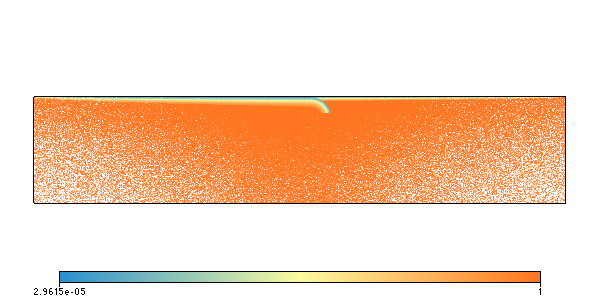

In [68]:
#Plot the proxyTempVariable, which represents the temperature ICs on the swarm

fig = glucifer.Figure(figsize=(600, 300))
fig.append( glucifer.objects.Points(swarm, proxyTempVariable))
fig.show()
#fig.save_database('test.gldb')

##  Manage subduction interface evolution


In this section we setup some functions to help manage the spatial distribution of embedded faults

These functions are basically binary functions on the model domain, that allow us to remove particles from the embedded faults where a function is True

We will remove particles in the swarm attached to the fault using the `faultRmfn`

In [69]:
tm.variable_boundary_mask_fn

<bound method TectonicModel.variable_boundary_mask_fn of <UWsubduction._tectonicmodel.TectonicModel object at 0x7f5bd4d22c10>>

In [70]:
# Setup a swarm to define the replacment positions for adding particles to the subduction fault

fThick= efCollection[0].thickness
faultloc = 1. - nmd.faultThickness*nmd.faultLocFac
allxs = np.arange(mesh.minCoord[0], mesh.maxCoord[0], ds )[:-1]
allys = (mesh.maxCoord[1] - fThick)*np.ones(allxs.shape)

faultMasterSwarm = uw.swarm.Swarm( mesh=mesh )
dummy =  faultMasterSwarm.add_particles_with_coordinates(np.column_stack((allxs, allys)))
del allxs
del allys



# faultRmfn is an example of a mask function, a function that returns a binary value
# several such must functions can be generated from the TectonicModel object
# the faultRmfn used to remove any embedded fault particles that lie  the ridge
# this helps to stup the plate subduction at ridge.


faultRmfn = tm.variable_boundary_mask_fn(distMax = ndimlz(100*ur.km),
                                           distMin = ndimlz(20*ur.km), 
                                           relativeWidth = 0.1,
                                           boundtypes='ridge')





faultAddFn =  fn.misc.constant(True)




## Proximity

Proximity refers to the relationship between the 1D embedded fault swarm, and the global material swarm. 

The method `set_proximity_director` updates the global swarm variable called `proximityVariable`, which takes integer values of 0 and 1. Any particles that are near the embedded fault swarm are set by 1. The definition of near is set by arguments to the `set_proximity_director`.

`minDistanceFn`, and `maxDistanceFn` define how thin and and thick the subduction interface is allowed to grow, relative to the initial fault thickness ( i.e. md.faultThickness).

Here minDistanceFn is depth dependent. Up to a depth defined by md.faultViscDepthTaperStart, we prescribe a minumum subduction interface thickness. Beyond this we do not prescribe a minumum subduction interface limit, but let the system adjust naturally.


In [143]:
if not cp.restart:
    #initialise proximity to 0 everywhere
    proximityVariable.data[:] = 0

In [193]:

minDistFac = 1.0

minDistInitFac = 1.9 #build interface out to this dist initially
maxDistFac = 1.9


#We enforce maximum fault thickness limits everywhere in the domain
#Note that these functions are provided as  a dimensionless fraction relative to the ndm.faultThickness
#this is beacause the interface2D object already knows its 'reference' thickness
proximityMaxDistFn = fn.misc.constant(maxDistFac)

#We enforce minumum thickness limits down to a depth specified by nmd.faultViscDepthTaperStart
#note that this depth value is also used later in defining the viscosity function of the embedded fault
#a cosine taper is used to transition from minDistInitFac to minDistFac, over a depth equal to the fault thickness 

mddTaperFn = 1. - usub.cosine_taper(depthFn, nmd.faultViscDepthTaperStart, width= maxDistFac*nmd.faultThickness )
proximityMinDistInitFn =  mddTaperFn* minDistInitFac + mddTaperFn*minDistFac
proximityMinDistFn = mddTaperFn* minDistFac



for f in efCollection:
    f.rebuild() #this is important for restarts
    
    #this is only to initialize the embedded fault proximity region
    if not cp.restart:

        f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0,
                                    minDistanceFn=proximityMinDistInitFn,
                                    maxDistanceFn=proximityMaxDistFn)
        


In [194]:
#together these functions will add particles to the embedded fault where we want them
#remove them where they are not wanted
#maintain the particle density and apply some smoothing

dummy = usub.remove_fault_drift(efCollection, faultloc)
dummy = usub.pop_or_perish(tm, efCollection, faultMasterSwarm, faultAddFn , ds)
dummy = usub.remove_faults_from_boundaries(tm, efCollection, faultRmfn )

In [195]:
#glucifer.Figure?


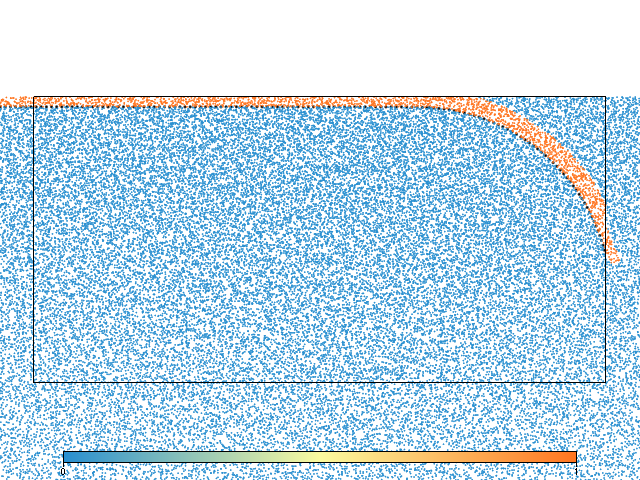

In [196]:
figProx = glucifer.Figure(  boundingBox=((-0.1, 0.9), (0.1, 1.0)), edgecolour='None'  )

figProx.append( glucifer.objects.Points(swarm , proximityVariable,  pointSize=2.5))

for f in efCollection:
    figProx.append( glucifer.objects.Points(f.swarm, pointSize=4))
figProx.show()

figProx.append( glucifer.objects.Mesh(mesh))



## Project the swarm 'proxy temp' to mesh

The temperature initial conditions initially constructed as a variable on the material swarm. We now project this to the mesh variable that we will use in solving the temperature evolution. 

In [156]:
if not cp.restart:
    
    projectorMeshTemp= uw.utils.MeshVariable_Projection( temperatureField, proxyTempVariable , type=0 )
    projectorMeshTemp.solve()

## Boundary conditions

In [157]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls = mesh.specialSets["MinJ_VertexSet"]
rWalls = mesh.specialSets["MaxI_VertexSet"]
all_walls = mesh.specialSets["AllWalls_VertexSet"]


In [158]:
#vXnodes
Fixed = mesh.specialSets["Empty"]
fixNode = rWalls & bWalls
Fixed += fixNode 

In [159]:
velBC  = uw.conditions.DirichletCondition( variable        = velocityField, 
                                           indexSetsPerDof = (iWalls, jWalls) )
        
    


In [160]:
#temperature is enforced along sidewalls

dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls + iWalls,) )

##If we want thermal ridges fixed
temperatureField.data[iWalls.data] = npd.potentialTemp_

In [161]:
## Reassert the temp boundary conditions, in case they have been altered in any way

temperatureField.data[tWalls.data] = npd.surfaceTemp_
temperatureField.data[bWalls.data] = npd.potentialTemp_

## Material properties


In [162]:
#create the gravity vector (the magnutude is encapsulated in the Rayleigh number)
gravity = ( 0.0, -1.0 )

thermalDensityFn = rayleighNumber*(1. - temperatureField)

buoyancyMapFn = thermalDensityFn*gravity

In [163]:
#define a diffusivity function. 
#here we use a constant diffusivity

diffusivityFn = 1.

In [164]:
#Set up any functions required by the rheology

symStrainrate = fn.tensor.symmetric( 
                            velocityField.fn_gradient )


strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))



def safe_visc(func, viscmin=nmd.viscosityMin, viscmax=nmd.viscosityMax):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))

In [165]:
adiabaticCorrectFn = depthFn*npd.adiabaticTempGrad
dynamicPressureProxyDepthFn = pressureField/pressureDepthGrad
druckerDepthFn = fn.misc.max(0.0, depthFn + (dynamicPressureProxyDepthFn))

## plate/mantle creep law

diffusionUM = (npd.diffusionPreExp)*\
    fn.math.exp( ((npd.diffusionEnergyDepth + \
                   (depthFn*npd.diffusionVolumeDepth))/((temperatureField+ adiabaticCorrectFn + npd.surfaceTemp))))

diffusionUM =     safe_visc(diffusionUM)
    
diffusionLM = npd.lowerMantleViscFac*(npd.diffusionPreExpLM)*\
    fn.math.exp( ((npd.diffusionEnergyLMDepth + \
                   (depthFn*npd.diffusionVolumeLMDepth))/((temperatureField+ adiabaticCorrectFn + npd.surfaceTemp))))

diffusionLM =     safe_visc(diffusionLM)

transitionZoneTaperFn = usub.cosine_taper(depthFn, nmd.lowerMantleDepth - 0.5*nmd.lowerMantleTransWidth , 
                                          nmd.lowerMantleTransWidth )


mantleCreep = diffusionUM*(1. - transitionZoneTaperFn) + transitionZoneTaperFn*diffusionLM

# plate/mantle plasticity

ys =  npd.cohesionMantle + (druckerDepthFn*npd.frictionMantleDepth)
ysf = fn.misc.min(ys, npd.yieldStressMax)
yielding = ysf/(2.*(strainRate_2ndInvariant) + 1e-15) 

if nmd.harmonicAvg:
    mantleRheologyFn =  safe_visc(mantleCreep*yielding/(mantleCreep + yielding), 
                                  viscmin=nmd.viscosityMin, viscmax=nmd.viscosityMax)
else:
    mantleRheologyFn =  safe_visc(fn.misc.min(mantleCreep,yielding), 
                                  viscmin=nmd.viscosityMin, viscmax=nmd.viscosityMax)
    
#rheology of the subduction interface

interfaceCreep = npd.viscosityFault

interfaceysf =  npd.frictionFault

if not nmd.plasticInterface:
    faultViscosityFn = npd.viscosityFault
    
else: #pseudo-brittle interface
    faultYielding = interfaceysf/(2.*(strainRate_2ndInvariant) + 1e-15)
    #combine
    faultViscosityFn = fn.misc.min(npd.viscosityFault, faultYielding)
    
    


In [168]:
#this is how the depth limit on the subduction interface is imposed
#the rheology function transitions from the value of faultViscosityFn
#to the value of the mantle viscosiity function over the depth interval prescribed by
#nmd.faultThickness

faultDepthTaperFn = usub.cosine_taper(depthFn, 
                                 nmd.faultViscDepthTaperStart, nmd.faultThickness)

faultRheologyFn =  faultViscosityFn*(1. - faultDepthTaperFn) +  \
                       faultDepthTaperFn*mantleRheologyFn





In [169]:
#map the viscosity 

viscosityMapFn = fn.branching.map( fn_key = proximityVariable,
                             mapping = {0:mantleRheologyFn,
                                        1:faultRheologyFn} )    

## Set up the Stokes system

In [170]:
surfaceArea = uw.utils.Integral(fn=1.0,mesh=mesh, integrationType='surface', surfaceIndexSet=tWalls)
surfacePressureIntegral = uw.utils.Integral(fn=pressureField, mesh=mesh, integrationType='surface', surfaceIndexSet=tWalls)

NodePressure = uw.mesh.MeshVariable(mesh, nodeDofCount=1)
Cell2Nodes = uw.utils.MeshVariable_Projection(NodePressure, pressureField, type=0)
Nodes2Cell = uw.utils.MeshVariable_Projection(pressureField, NodePressure, type=0)

def smooth_pressure(mesh):
    # Smooths the pressure field.
    # Assuming that pressure lies on the submesh, do a cell -> nodes -> cell
    # projection.

    Cell2Nodes.solve()
    Nodes2Cell.solve()

# a callback function to calibrate the pressure - will pass to solver later

def pressure_calibrate():
    (area,) = surfaceArea.evaluate()
    (p0,) = surfacePressureIntegral.evaluate()
    offset = p0/area
    pressureField.data[:] -= offset
    smooth_pressure(mesh)

In [171]:
stokes = uw.systems.Stokes( velocityField  = velocityField, 
                                   pressureField  = pressureField,
                                   conditions     = [velBC,],
                                   fn_viscosity   = viscosityMapFn, 
                                   fn_bodyforce   = buoyancyMapFn)



In [172]:
solver = uw.systems.Solver(stokes)

solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4


In [173]:
if not cp.restart:
    solver.solve(nonLinearIterate=True, nonLinearTolerance=nmd.nltol, callback_post_solve = pressure_calibrate)
    solver.print_stats()


 
Pressure iterations:   3
Velocity iterations:   1 (presolve)      
Velocity iterations:   3 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   5 (total solve)   
 
SCR RHS  setup time: 3.3227e-01
SCR RHS  solve time: 3.6616e-03
Pressure setup time: 1.0757e-03
Pressure solve time: 1.4281e-02
Velocity setup time: 4.7684e-07 (backsolve)
Velocity solve time: 3.1648e-03 (backsolve)
Total solve time   : 3.9788e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



## Set up the advection - diffusion system

In [187]:
if not nmd.slade:
    advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                             phiDotField    = temperatureDotField, 
                                             velocityField  = velocityField,
                                             fn_sourceTerm    = 0.0,
                                             fn_diffusivity  = diffusivityFn,
                                             conditions     = [ dirichTempBC], 
                                             _allow_non_q1=True)

else:
    advDiff  = uw.systems.SLCN_AdvectionDiffusion( phiField       = temperatureField,
                                                     velocityField  = velocityField, 
                                                     #fn_diffusivity = uw.function.misc.constant(npd.refDiffusivity),
                                                     fn_diffusivity  = diffusivityFn,
                                                     conditions     = [dirichTempBC])

## Swarm Advector

In [190]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )


In [191]:
population_control = uw.swarm.PopulationControl(swarm, deleteThreshold=0.006, 
                                                splitThreshold=0.25,maxDeletions=1, maxSplits=3, aggressive=True,
                                                aggressiveThreshold=0.9, particlesPerCell=int(nmd.ppc))

## Update functions

A set of functions that will be called in the simulations

* advect_update: advects the material swarm and swarms associated with faults (e.g the subduction interface)
* update_faults: apply smoothing operatiions to the swarms associated with faults and remove particles based on certain spatial conditions
* updates_swarm: apply population control and rebuild the proximity variable
* update_tect_model: update the tectModel that location of plate boundaries,
* update_mask_fns: the mask functions determine where we want to add particles to the swarms associated with faults
* xdmfs_update: write some mesh variables in xdmf format


In [174]:
# Here we'll handle all the swarms that need to be advected

def advect_update(dt):
    
    #Advect the material swarm
    advector.integrate(dt) 
    
    #Advect faults
    for f in efCollection:
        f.advection(dt)
    
    
    return time+dt, step+1

In [175]:
def update_faults():
    
    
    #order is very important here. These functions are designed ensure smoothness and adequate density of the
    #1d suduction interface swarms  
    
    dummy = usub.remove_fault_drift(efCollection, faultloc)
    dummy = usub.pop_or_perish(tm, efCollection, faultMasterSwarm, faultAddFn , ds)
    dummy = usub.remove_faults_from_boundaries(tm, efCollection, faultRmfn )
    
    
    for f in efCollection:
        
        #Remove particles below a specified depth
        depthMask = f.swarm.particleCoordinates.data[:,1] <         (1. - nmd.faultDestroyDepth)
        with f.swarm.deform_swarm():
            f.swarm.particleCoordinates.data[depthMask] = (9999999., 9999999.)
        
        #The repair_interface2D routine is supposed to maintain particle density and smooth
        usub.interfaces.repair_interface2D(f, ds, smoothCycles=1, k=8)

In [197]:
def update_swarm():
    
    population_control.repopulate()
    
    for f in efCollection:
        
        f.rebuild() #will rebuild the fault normal property

        
        f.set_proximity_director(swarm, proximityVariable, searchFac = 2., locFac=1.0,
                                minDistanceFn=proximityMinDistFn,
                                maxDistanceFn=proximityMaxDistFn )
        
    #A simple depth cutoff for proximity
    depthMask = swarm.particleCoordinates.data[:,1] < (1. - nmd.faultDestroyDepth)
    proximityVariable.data[depthMask] = 0
    

In [198]:
def update_tect_model(tectModel, tmUwMap, time, dt = 0.0 ):
    
    """
    The main purpose of this function is to try to track the location of plate boundaries, 
    and update the TectonictModel object that stores them.
    
    If other functions are defined using the tectModel,
    then this function may be deterministic rather than diagnostic.
    
    """
    for e in tectModel.undirected.edges():
        
        #This is generally the first condition to check" a specified boundary velocity
        if tectModel.bound_has_vel(e, time):
            newX = usub.get_boundary_vel_update(tectModel, e, time, dt)
            tectModel.set_bound_loc(e, newX)
            
        #in this model the ficticious boundaries remain fixed at the edge
        elif e[0] == e[1]:
            pass       
        #now we'll apply a strain rate query to update the subduction zone loc
        elif tectModel.is_subduction_boundary(e):
            if tectModel.is_subduction_boundary(e):
                e = tectModel.subduction_edge_order(e) #ordering may not be important here...
            newx = usub.strain_rate_field_update(tectModel, e, tmUwMap, dist = ndimlz(100*ur.kilometer))
            tectModel.set_bound_loc(e, newx)
        else:
            pass
        



In [199]:
update_tect_model(tm, tmUwMap, 0, dt = 0.0 )

In [200]:
def update_mask_fns():

    faultRmfn = tm.variable_boundary_mask_fn(distMax = ndimlz(100*ur.km),
                                               distMin = ndimlz(20*ur.km), 
                                               relativeWidth = 0.1,
                                               boundtypes='ridge')



    faultAddFn =  fn.misc.constant(True)





    #the following dictates where the fault rheology will be activated

    subZoneDistfn = tm.subZoneAbsDistFn(nonSpVal=0.0, upper=False)
    
    return faultRmfn, faultAddFn

In [201]:
def xdmfs_update():
    
 
    try:
        _mH
    except:
        _mH = mesh.save(xdmfPath+"mesh.h5")
    
    #part1
    mh = _mH
    tH = temperatureField.save(xdmfPath + "temp_" + str(step) + ".h5")
    
    
    
    #part 2
    temperatureField.xdmf(xdmfPath + "temp_" + str(step), tH, 'temperature', mh, 'mesh', modeltime=time)


In [202]:
def write_checkpoint(step_, time_):
    cp.saveObjs(step_, time_)
    cp.saveDicts(step_, time_)

## Main Loop

In [203]:
time = cp.time()  # Initialise time
step = cp.step()   # Initialise timestep


#these could also go in the md dictionary
swarm_update = 2   # output every N timesteps
faults_update = 2
dt_model = 0.
steps_update_model = 5
files_freq  = nmd.filesMyr
files_this_step = False
next_image_step = (np.floor(time/files_freq)+ 1.) *files_freq 



In [204]:
#checkpoint at time zero
if not cp.restart:
    write_checkpoint(step, time)

In [ ]:
while time < tm.times[-1] and step < nmd.maxSteps:
    
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True, 
                 nonLinearTolerance=nmd.nltol, 
                 callback_post_solve = pressure_calibrate)
    
    if not nmd.slade:
        dt = advDiff.get_max_dt()*nmd.courantFix
    else:
        dt = advector.get_max_dt()*nmd.courantFix
        
    
    #here we modify dt, so that we hit certain time points for vizualisation consistency
    if step == 0:
        files_this_step = True
    else:
        files_this_step = False
    
    if time + dt >= next_image_step:
        dt = next_image_step - time
        files_this_step = True
        next_image_step += files_freq #increment time for our next image / file dump
            
    
    #solve/update the advection diffusion system
    advDiff.integrate(dt)
      
    
    #advect swarm and faults
    time, step =  advect_update(dt)
    dt_model += dt
        
        
    #update the tectonic model, and rebuild the rheology around the subduction fault (proximity)
    
    if step % steps_update_model == 0:
        
        update_tect_model(tm, tmUwMap, time, dt = dt_model)
        dt_model = 0.
        plate_id_fn = tm.plate_id_fn()
        faultRmfn, faultAddFn = update_mask_fns()
        
        #these rheology function need to be explicity updated
        
        faultRheologyFn =  faultViscosityFn*(1. - faultDepthTaperFn) +  \
                       faultDepthTaperFn*mantleRheologyFn

        
        viscosityMapFn = fn.branching.map( fn_key = proximityVariable,
                             mapping = {0:mantleRheologyFn,
                                        1:faultRheologyFn} )
        
    

        
    #running embedded fault particle addition/subtraction/healing, map back to swarm
    if step % faults_update == 0:
        update_faults()
        
    if step % swarm_update == 0:
        update_swarm()
        

    
    # output figure to file at intervals = steps_output
    if files_this_step:
        
        
        #XDMFS
        xdmfs_update()
        
    #checkpoint
    if step % nmd.checkpointEvery == 0:
        write_checkpoint(step, time)
    
    
    if uw.rank()==0:
        print 'step = {0:6d}; time = {1:.3e}'.format(step,time)


step =      1; time = 3.413e-07
step =      2; time = 6.850e-07
step =      3; time = 9.381e-07
step =      4; time = 1.226e-06
step =      5; time = 1.503e-06
step =      6; time = 1.795e-06
step =      7; time = 1.876e-06
step =      8; time = 2.191e-06
step =      9; time = 2.434e-06
